# TOPICAL CHAT EDA

# IMPORTING LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')

import regex as re

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.util import ngrams

import gensim

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud, ImageColorGenerator

import spacy

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))#to expand the size of my container so it can take fill up my entire monitor

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'

pd.options.display.max_rows = 200 #increasing maximum viewable rows and columns
pd.options.display.max_columns = 200

<b>Dataset:</b> <a href="https://www.kaggle.com/arnavsharmaas/chatbot-dataset-topical-chat">Chatbot Dataset Topical Chat</a>

The dataset I decided to use is a [topical chat dataset](https://www.kaggle.com/arnavsharmaas/chatbot-dataset-topical-chat) from Amazon that consists of 8,000+ conversations and 184,000+ messages.

It was created by Arnav Sharma and is a more streamlined version of [this](https://github.com/alexa/Topical-Chat) original Amazon Alexa dataset.

The dataset contains a conversation id, a message (which is either a reply or the start of a conversation), and the sentiment of each message.

The dataset spands 8 broad topics and contains conversation partner who do not have defined roles. It was created with the goal of [aiding in the effort to build a socialbot that can have deep, engaging open-domain conversations with humans](https://m.media-amazon.com/images/G/01/amazon.jobs/3079_Paper._CB1565131710_.pdf).

The eight broad topics are as follows:
- fashion
- politics
- books
- sports
- general entertainment
- music
- science and technology
- movies

In [3]:
topical = pd.read_csv('data/topical_chat.csv')

topical.head()

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,conversation_id,message,sentiment
0,1,Are you a fan of Google or Microsoft?,Curious to dive deeper
1,1,Both are excellent technology they are helpfu...,Curious to dive deeper
2,1,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper
3,1,Google provides online related services and p...,Curious to dive deeper
4,1,"Yeah, their services are good. I'm just not a...",Curious to dive deeper


# INITIAL DATASET CHECK

In [4]:
topical.shape

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(188378, 3)

In [5]:
topical.isnull().sum() #checking for nulls

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


conversation_id    0
message            0
sentiment          0
dtype: int64

In [6]:
topical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188378 entries, 0 to 188377
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   conversation_id  188378 non-null  int64 
 1   message          188378 non-null  object
 2   sentiment        188378 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.3+ MB


/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<br>

# SECTION 2: EXPLORATORY DATA ANALYSIS

<a href="https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools">NLP EDA workflow and process courtesy of Shahul ES.</a>

## 2.1 TEXT STATISTICS

In [8]:
text = topical['message']

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


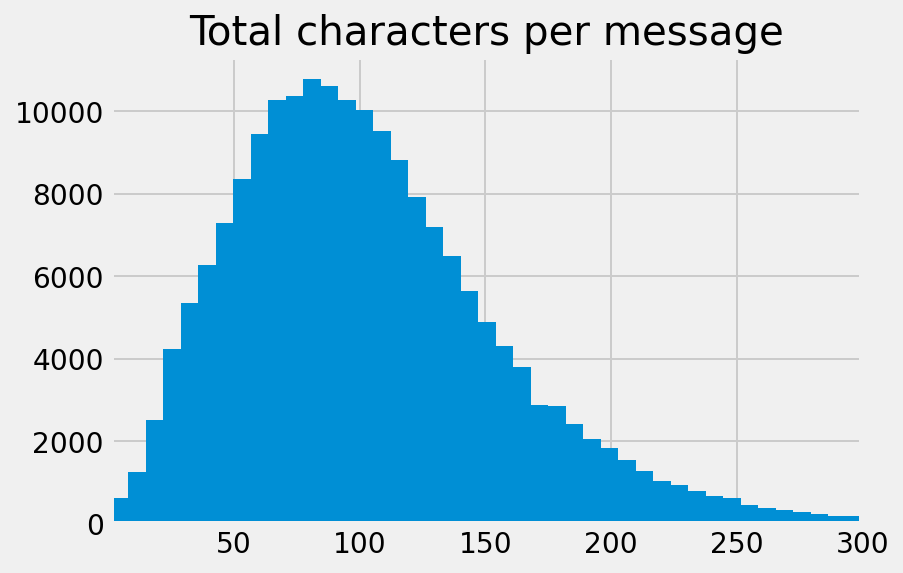

In [9]:
#total characters per message
text.str.len().hist(bins=100)
plt.xlim(1, 300)
plt.title("Total characters per message");

Message lengths seems to peak around 75-80 characters.

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


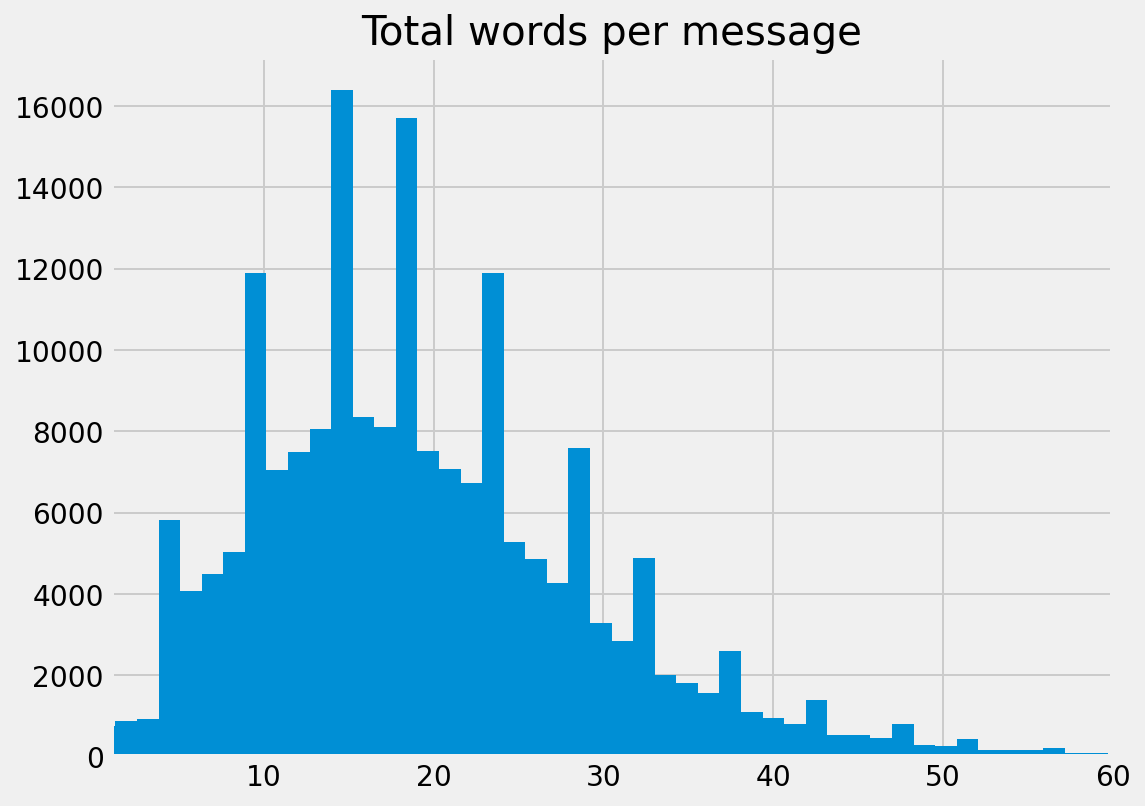

In [10]:
#total words per message
plt.figure(figsize=(8, 6))
text.str.split().map(lambda x: len(x)).hist(bins=100)
plt.xlim(1, 60)
plt.title("Total words per message";

This dataset strikes me as a little odd in terms of words per message because there are a lot of very high peaks at seemingly random (though clearl not random) intervals. 

It's almost as if the speakers were given specific numbers to hit for words per message in some instances.

In [11]:
from matplotlib.pyplot import figure


/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


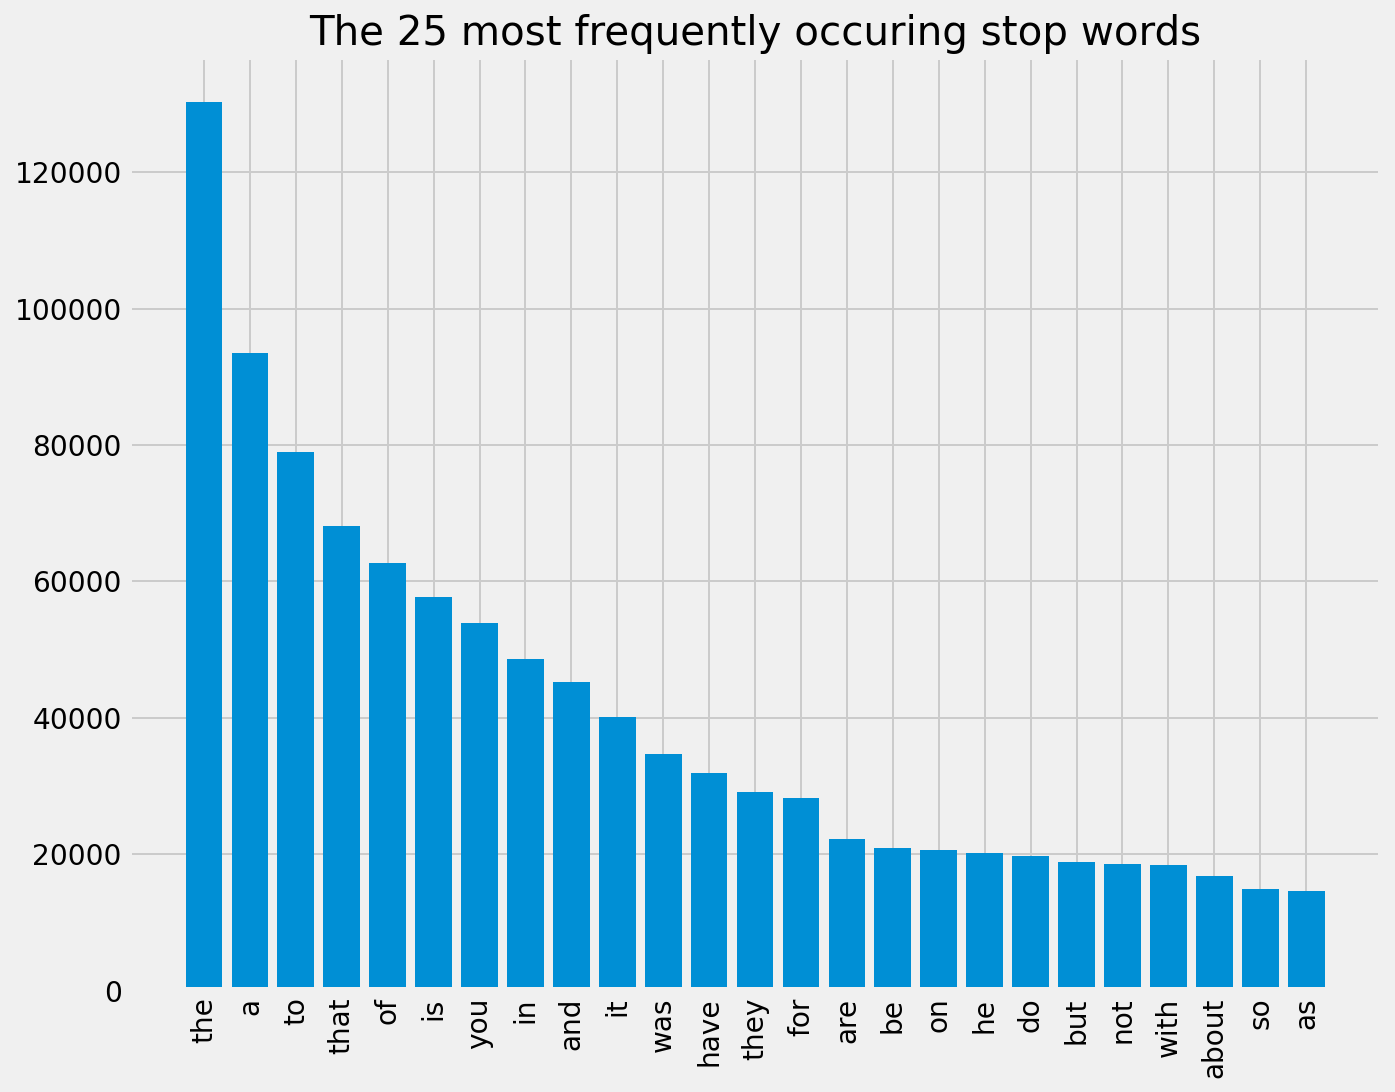

In [12]:
#stopword distribution
stop=set(stopwords.words('english'))
corpus=[]
new_text= text.str.split()
new_text=new_text.values.tolist()
corpus=[word for i in new_text for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
            
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:25] 
x,y=zip(*top)
plt.figure(figsize=(10, 8))
plt.bar(x,y)
plt.xticks(rotation=90)
plt.title("The 25 most frequently occuring stop words");
# plt.figure(figsize=(18, 6));

"The", "a", "to", and "that" are the most frequently occuring stopwords.  

In [13]:
from collections import Counter

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


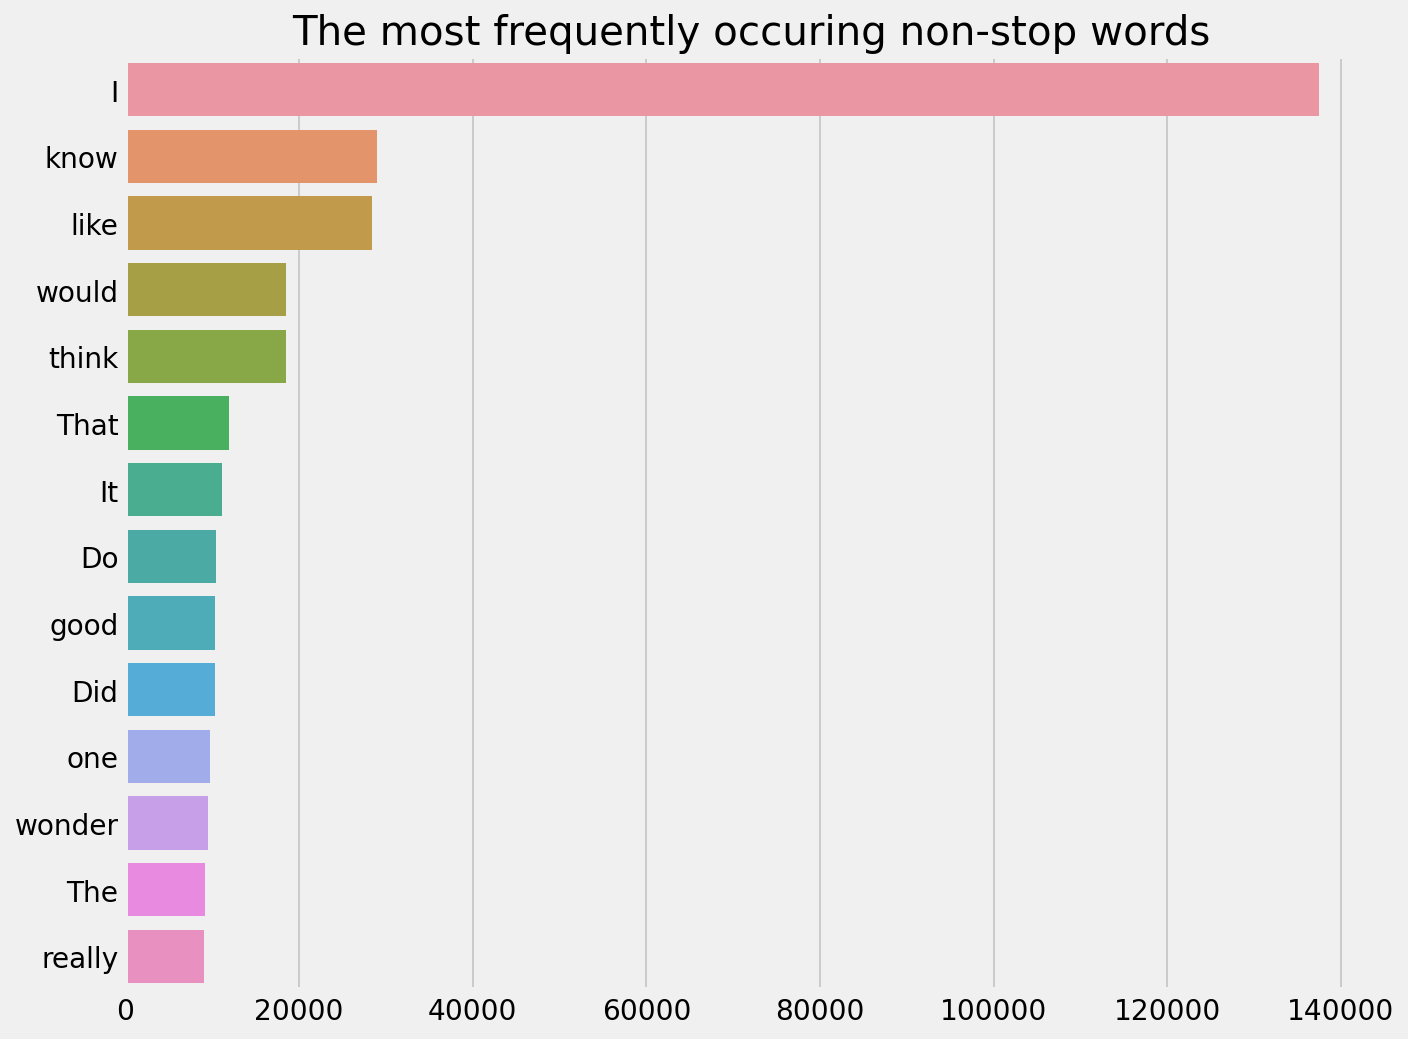

In [14]:
#non-stopword distribution
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:50]:
    if (word not in stop):
        x.append(word)
        y.append(count)
plt.figure(figsize=(10, 8))        
sns.barplot(x=y,y=x)
plt.title("The most frequently occuring non-stop words");

The frequency of the word "I" dwarfs every other word.

Perhaps this suggests that Amazon encoraged people to give personal opinions during the creation of this dataset. That or humans just have a natuaral affinity for the word "I" and making their opinions known.

Personally, I did not anticipate I to be as utterly dominate in this category as it's turned out to be.

This understanding will definitely help my chatbot.

Interestingly, I saw a similar thing with movie dialogue, but in that instance "you" was second. In this instance, "you" is completely absent.  

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


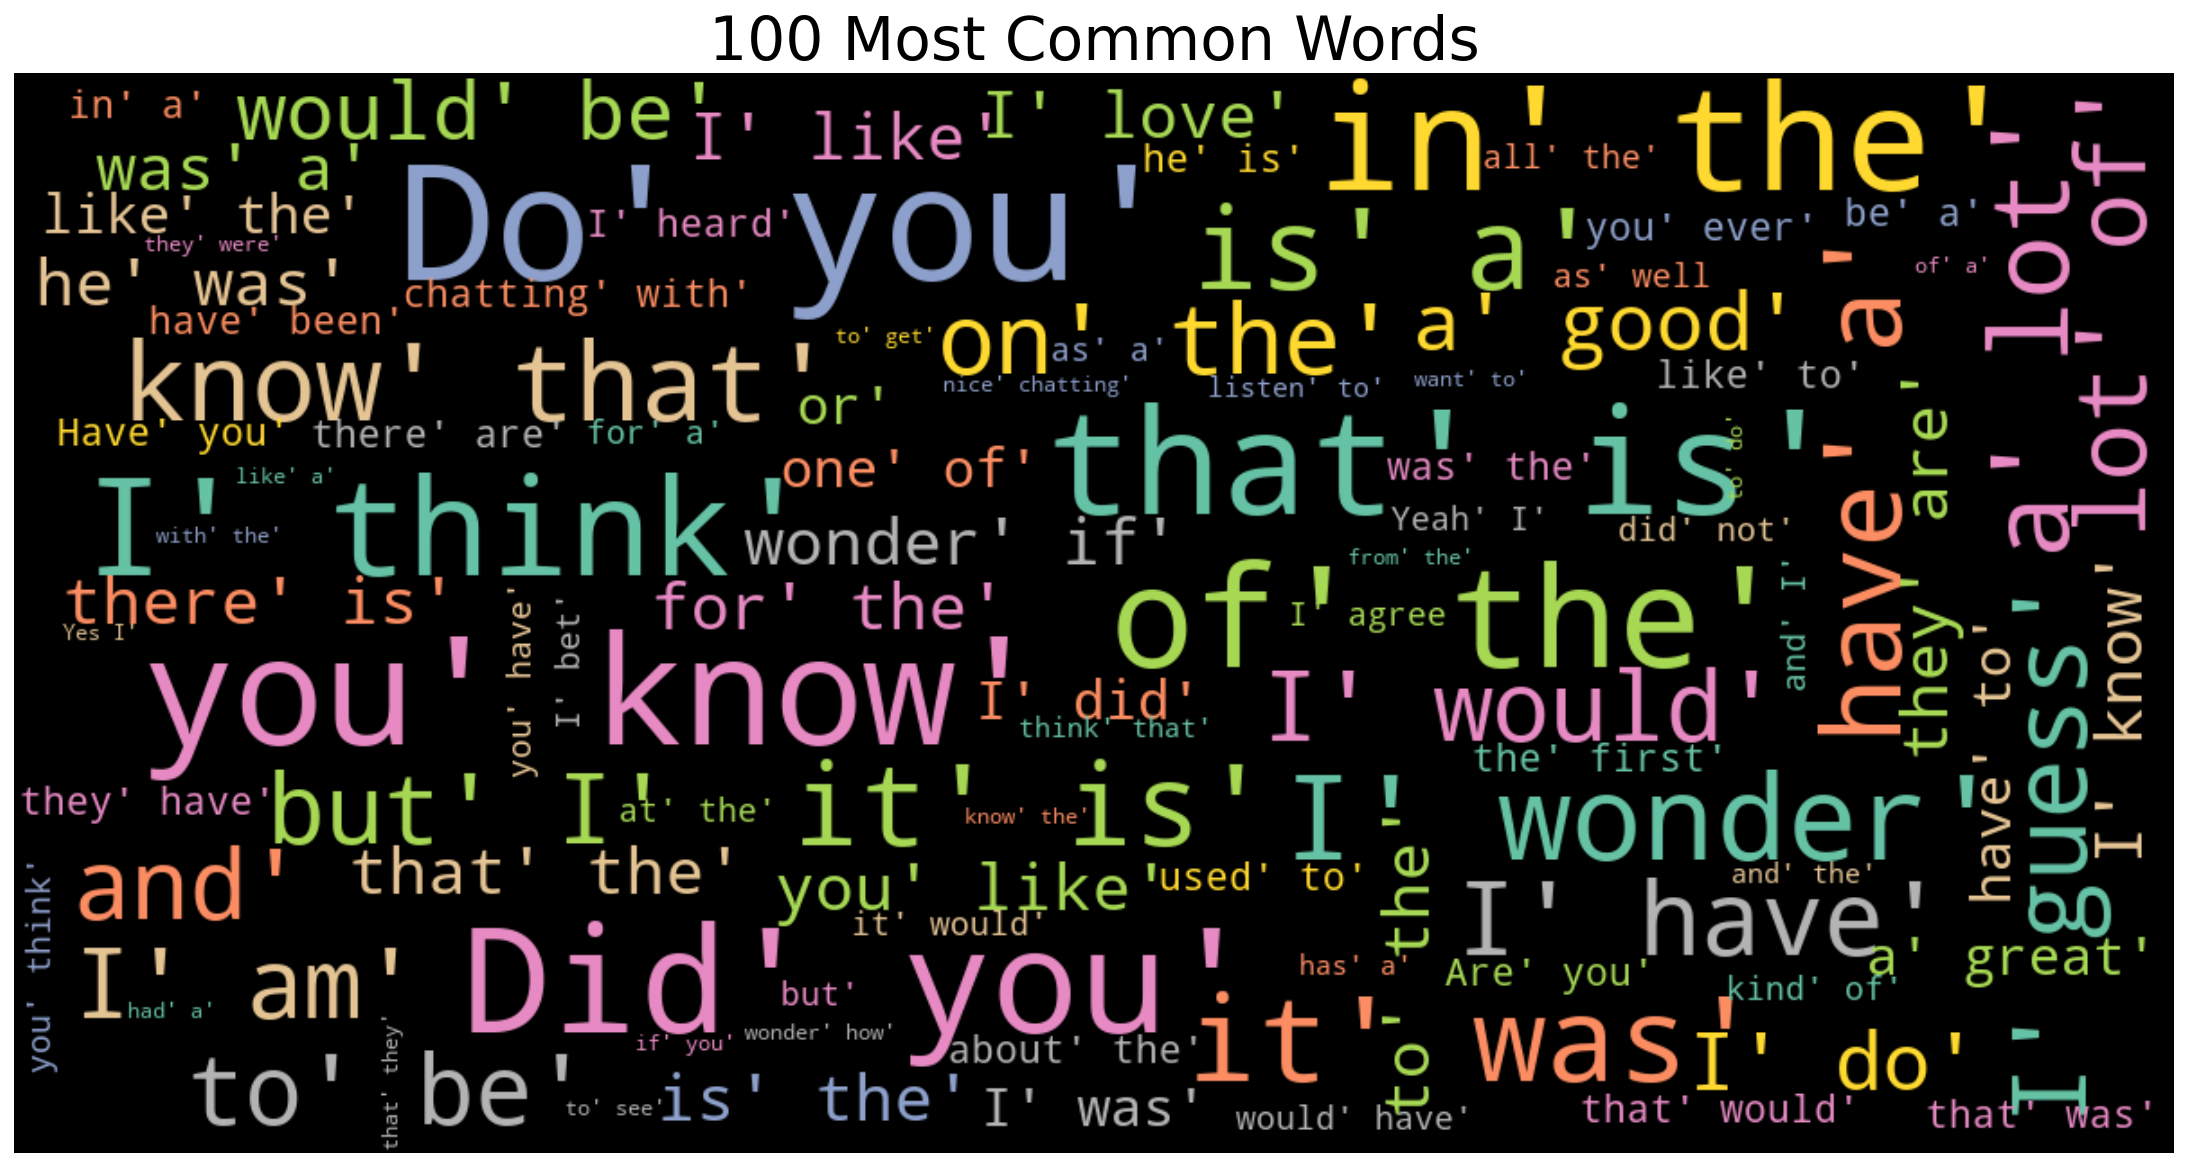

In [15]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='black',
        colormap='Set2',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(figsize=(15,10), facecolor='white')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title('100 Most Common Words', fontsize=30)
    plt.tight_layout(pad=0)
    plt.show()

show_wordcloud(corpus);

<br>

## 2.1 N-GRAM EXPLORATION

In [16]:
#function to get the most frequent n-grams
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
def plot_n_gram(corpus, n):
    top_n_grams=get_top_ngram(corpus,n)[:20]
    x,y=map(list,zip(*top_n_grams))
    plt.figure(figsize=(10, 8))
    sns.barplot(x=y,y=x)
    plt.xlabel("Count")
    plt.ylabel("N-gram")
    plt.title("Top Combinations")


/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2.1.1 N = 2

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


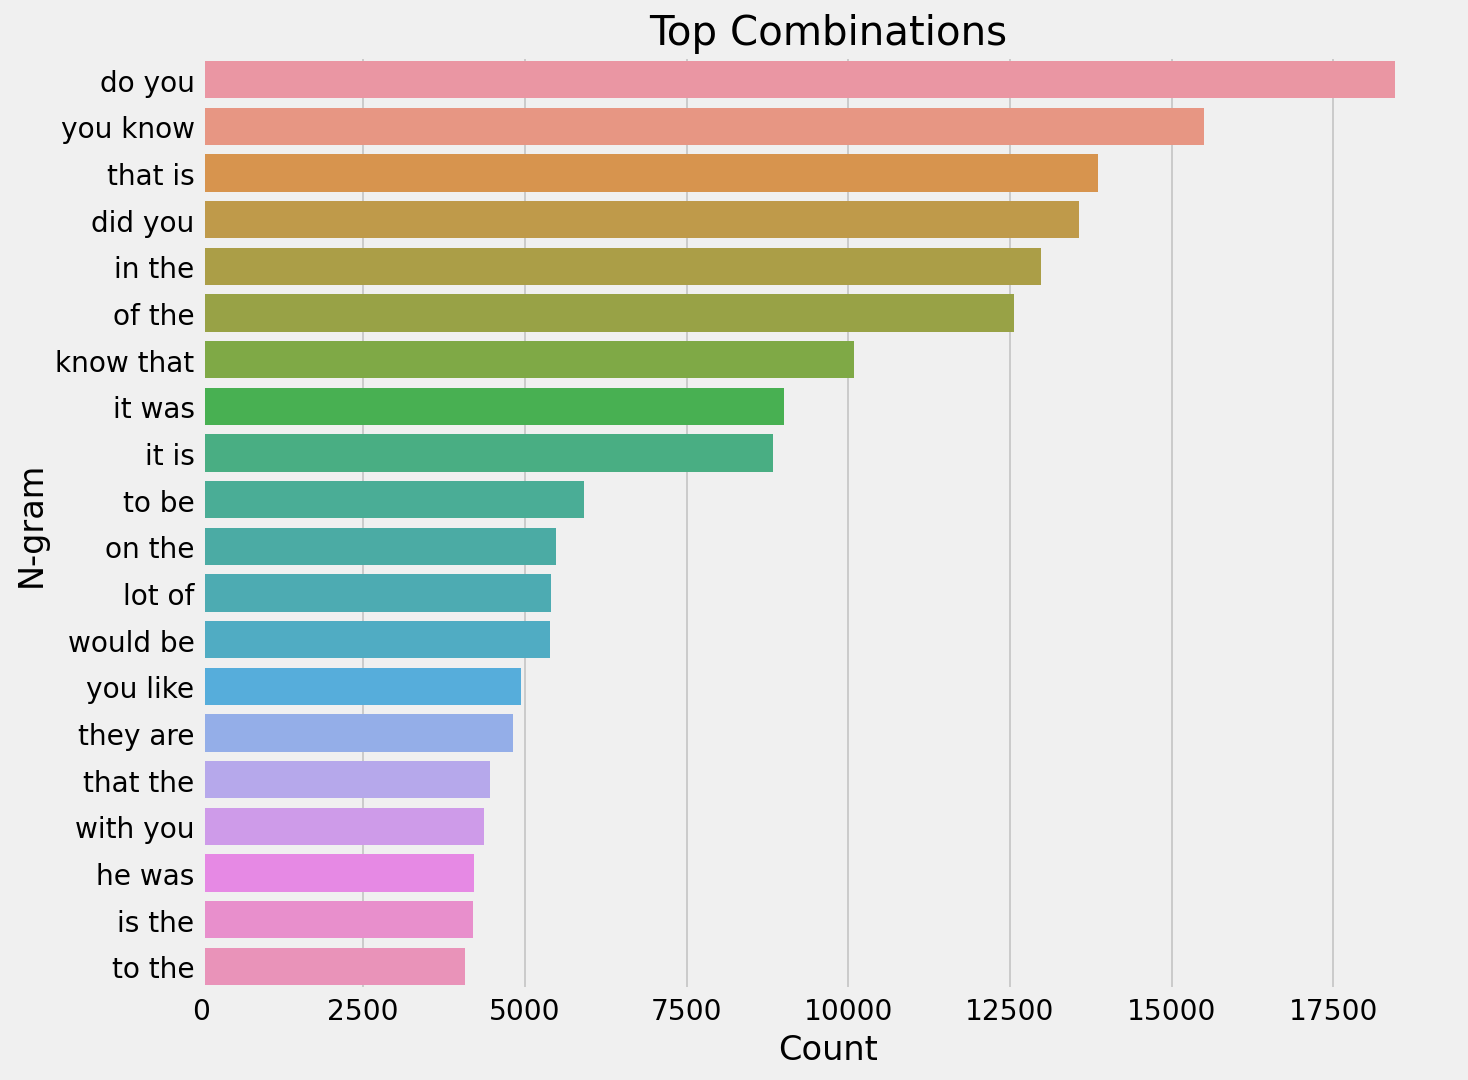

In [18]:
plot_n_gram(text, 2);

In terms of bigrams there's nothing unexpected. They make sense since this dataset was created by having people dialogue with one another without a predetermined role. 

Asking others about themselves is a typical way to keep conversation going, hence the frequency of the word "you" in bigrams.

<br>

## 2.1.2 N = 3

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


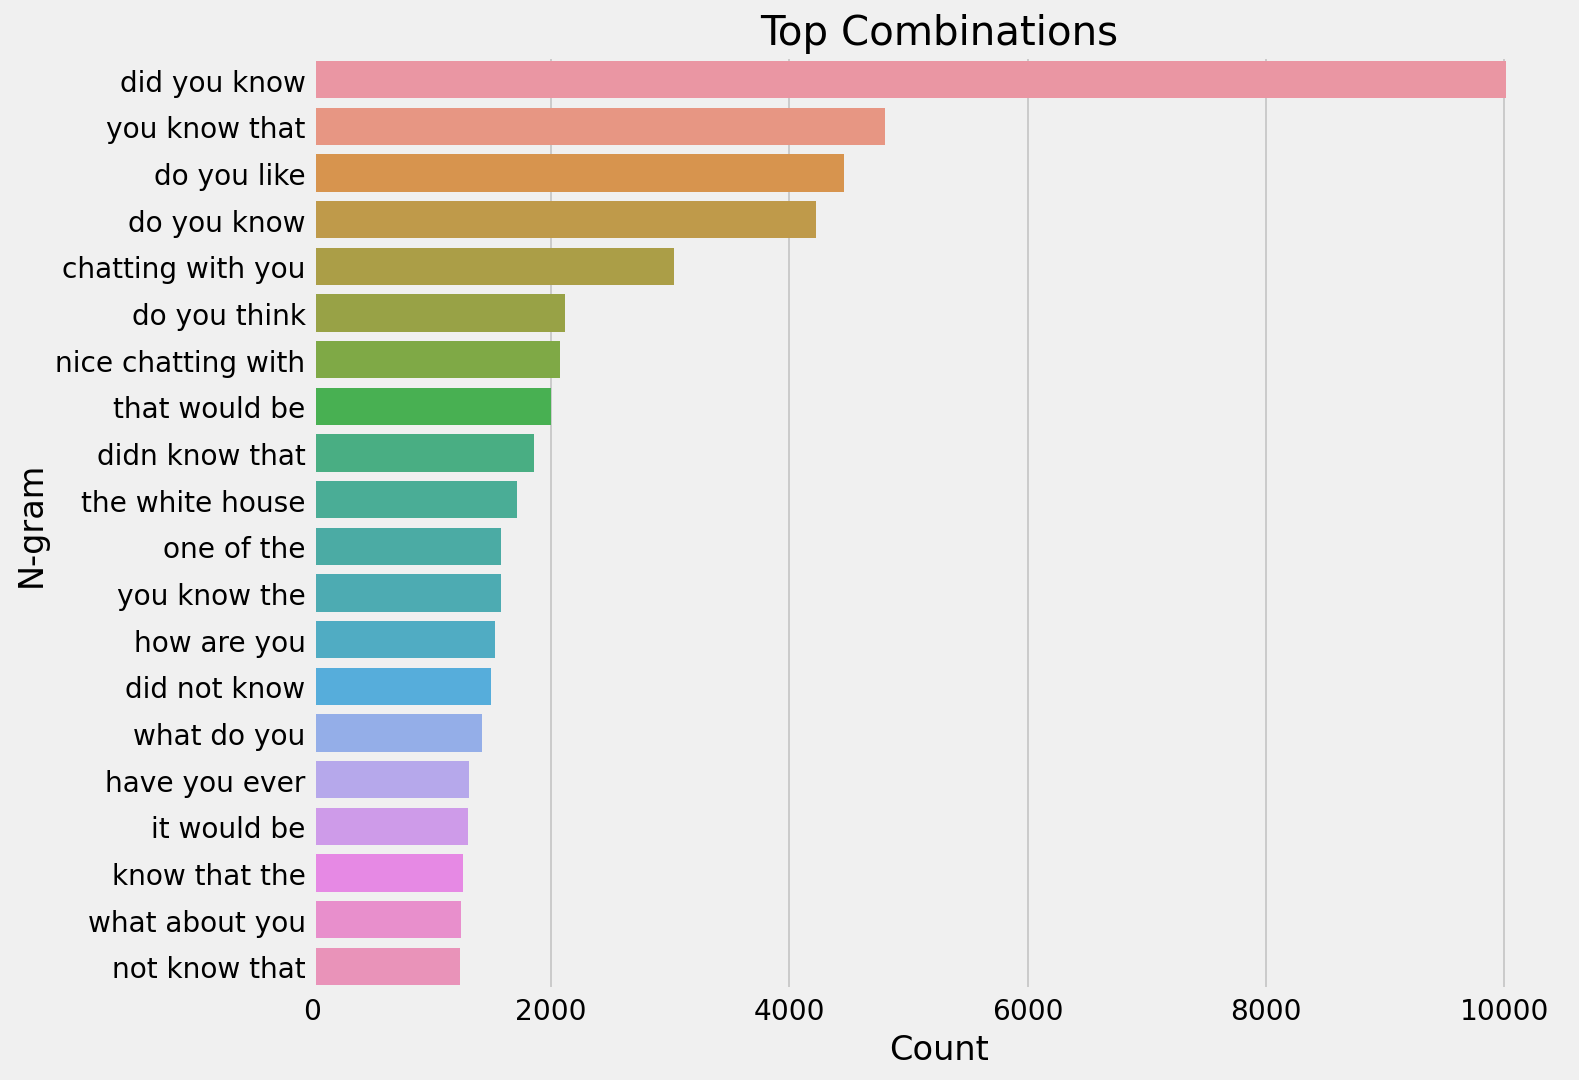

In [19]:
plot_n_gram(text, 3);

In terms of trigrams, it's clear that three word combinations lean heavily towards questions (ex. "did you know", "do you like", "do you know").

<br>

## 2.1.3 N = 4

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


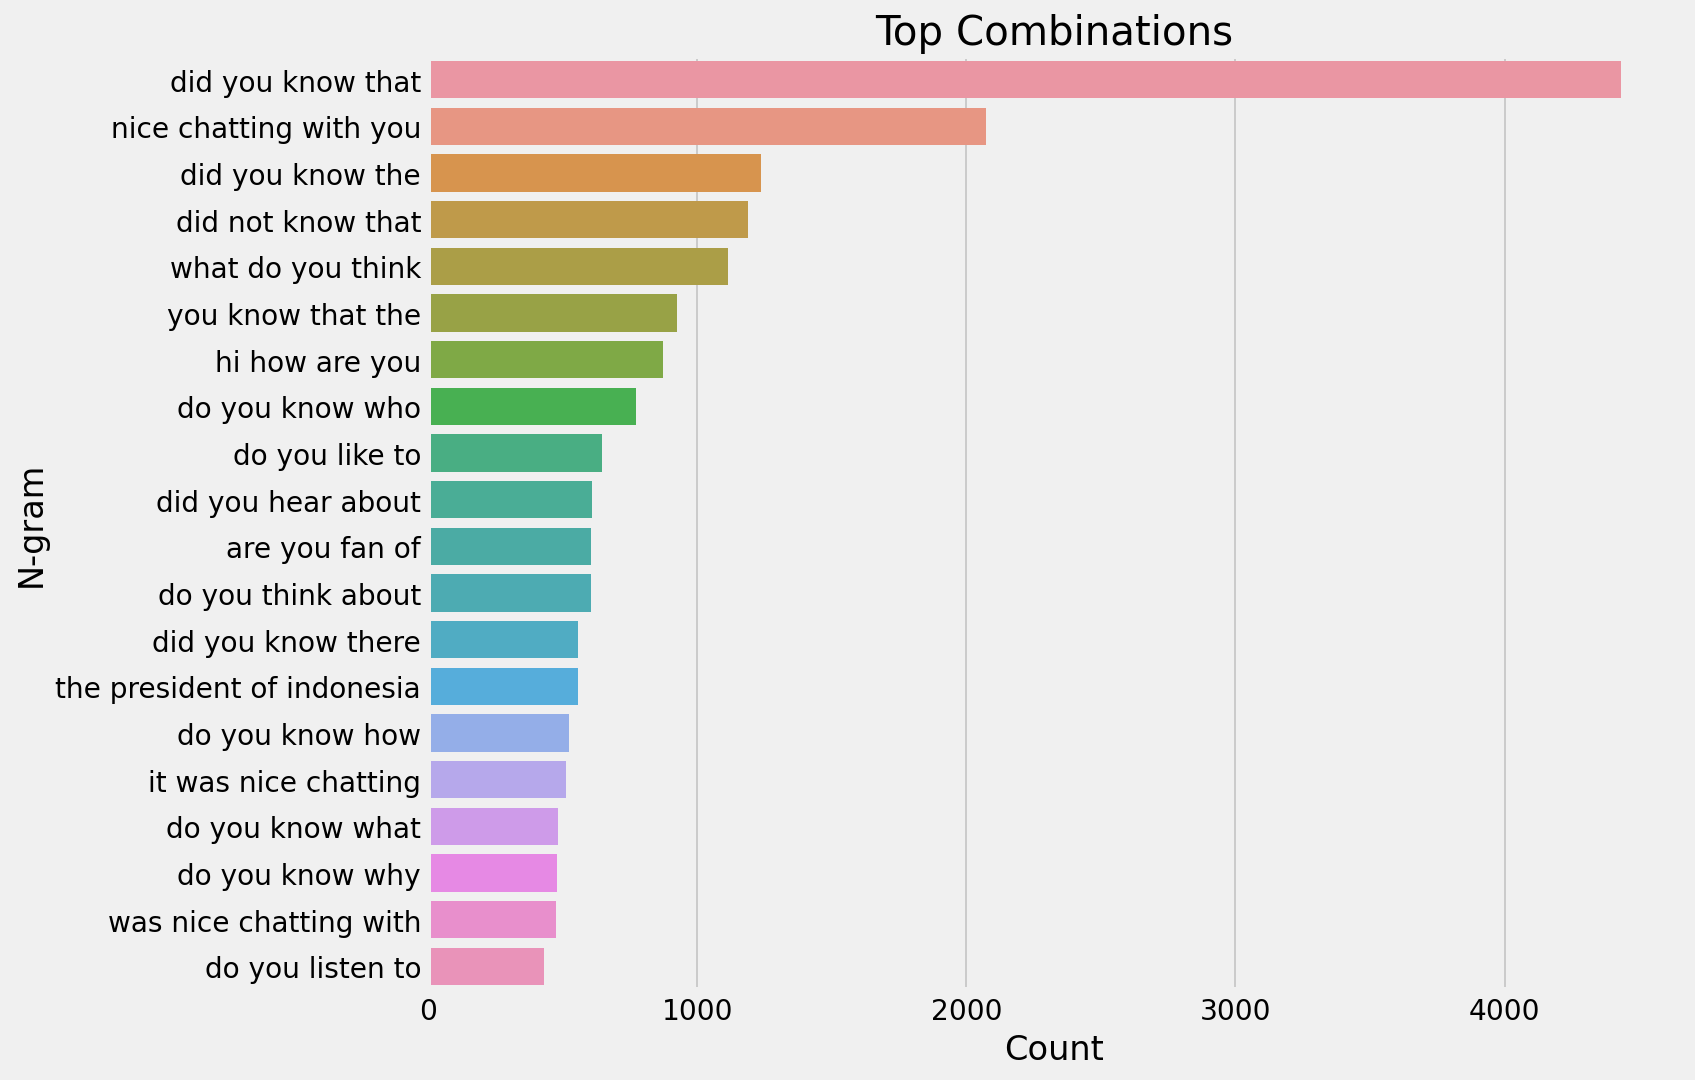

In [20]:
plot_n_gram(text, 4);

N-grams have 4 words in length seem to continue the patterns seen above with trigrams. 

<br>

## 2.1.3 N = 5

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


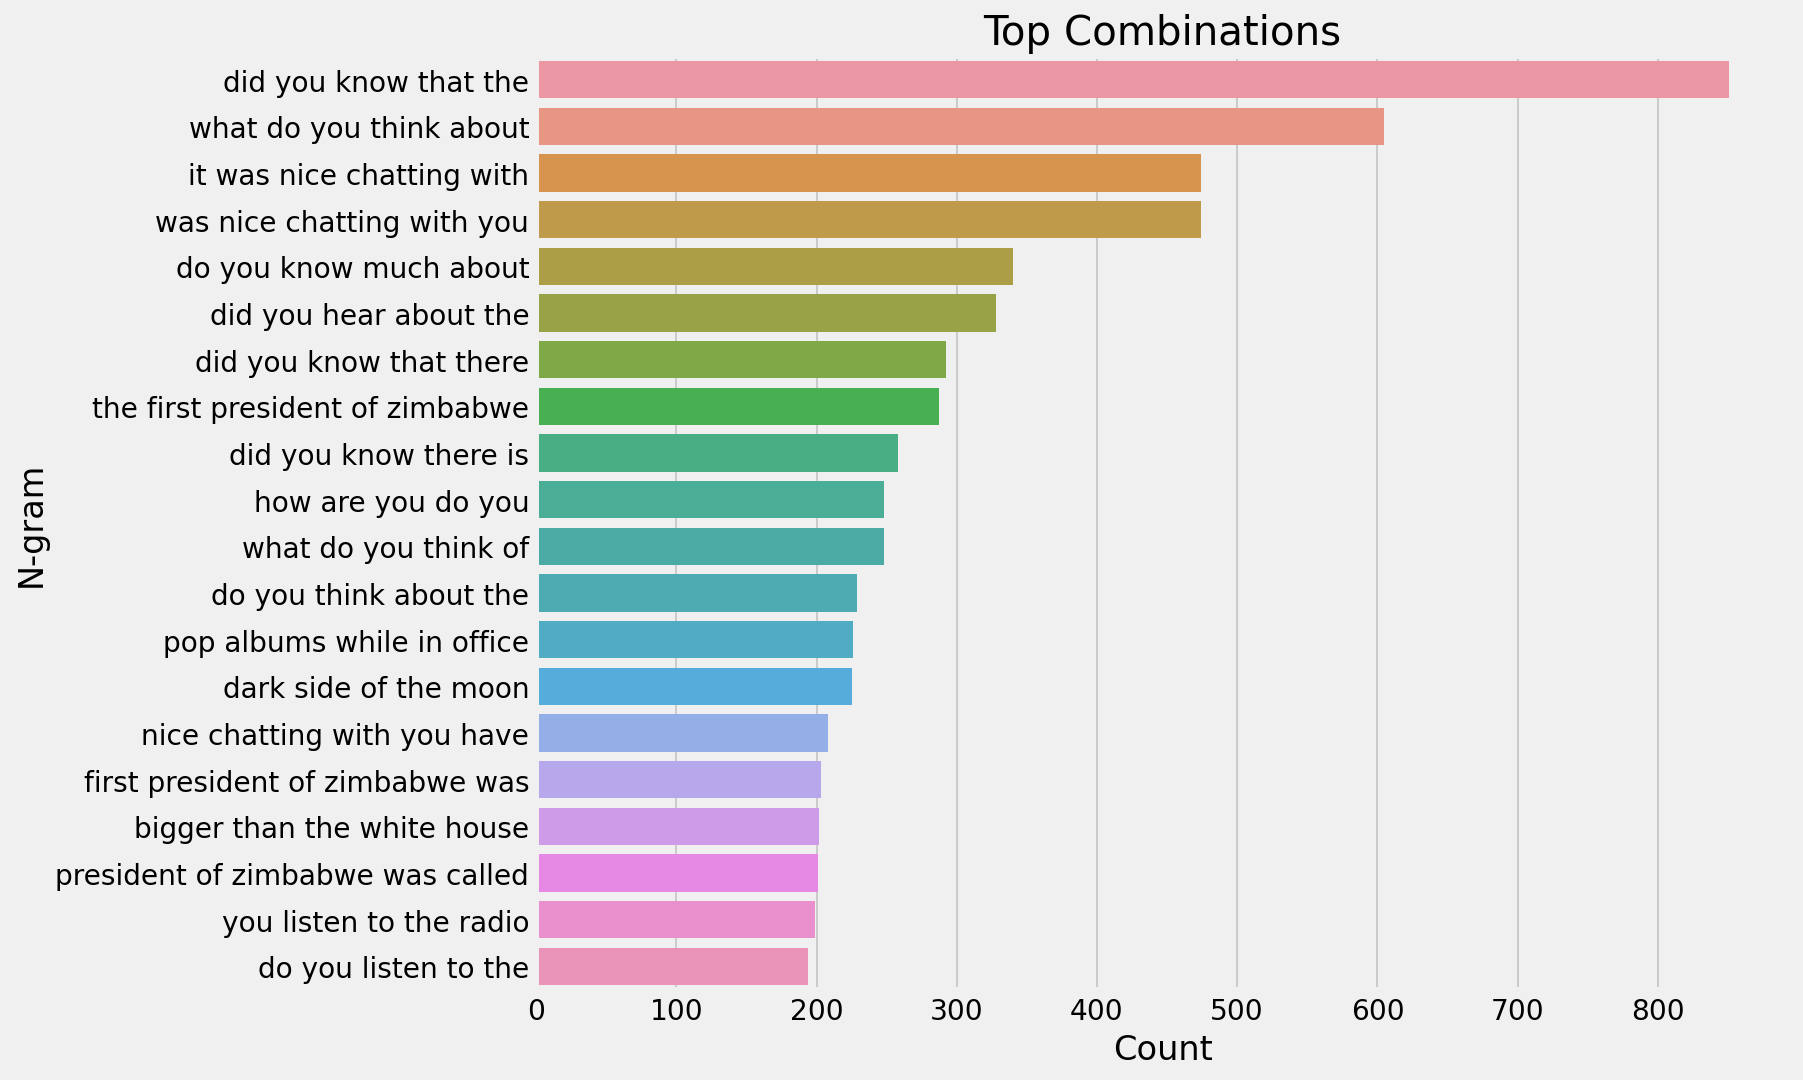

In [21]:
plot_n_gram(text, 5);

I must admit, I didn't anticipate seeing the word "zimbabwe" so frequently here. 

That leads me to think that perhaps Zimbabwe must have been big in the news cycle during the period that this data was collected.

<br>

## 2.1.3 N = 6

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


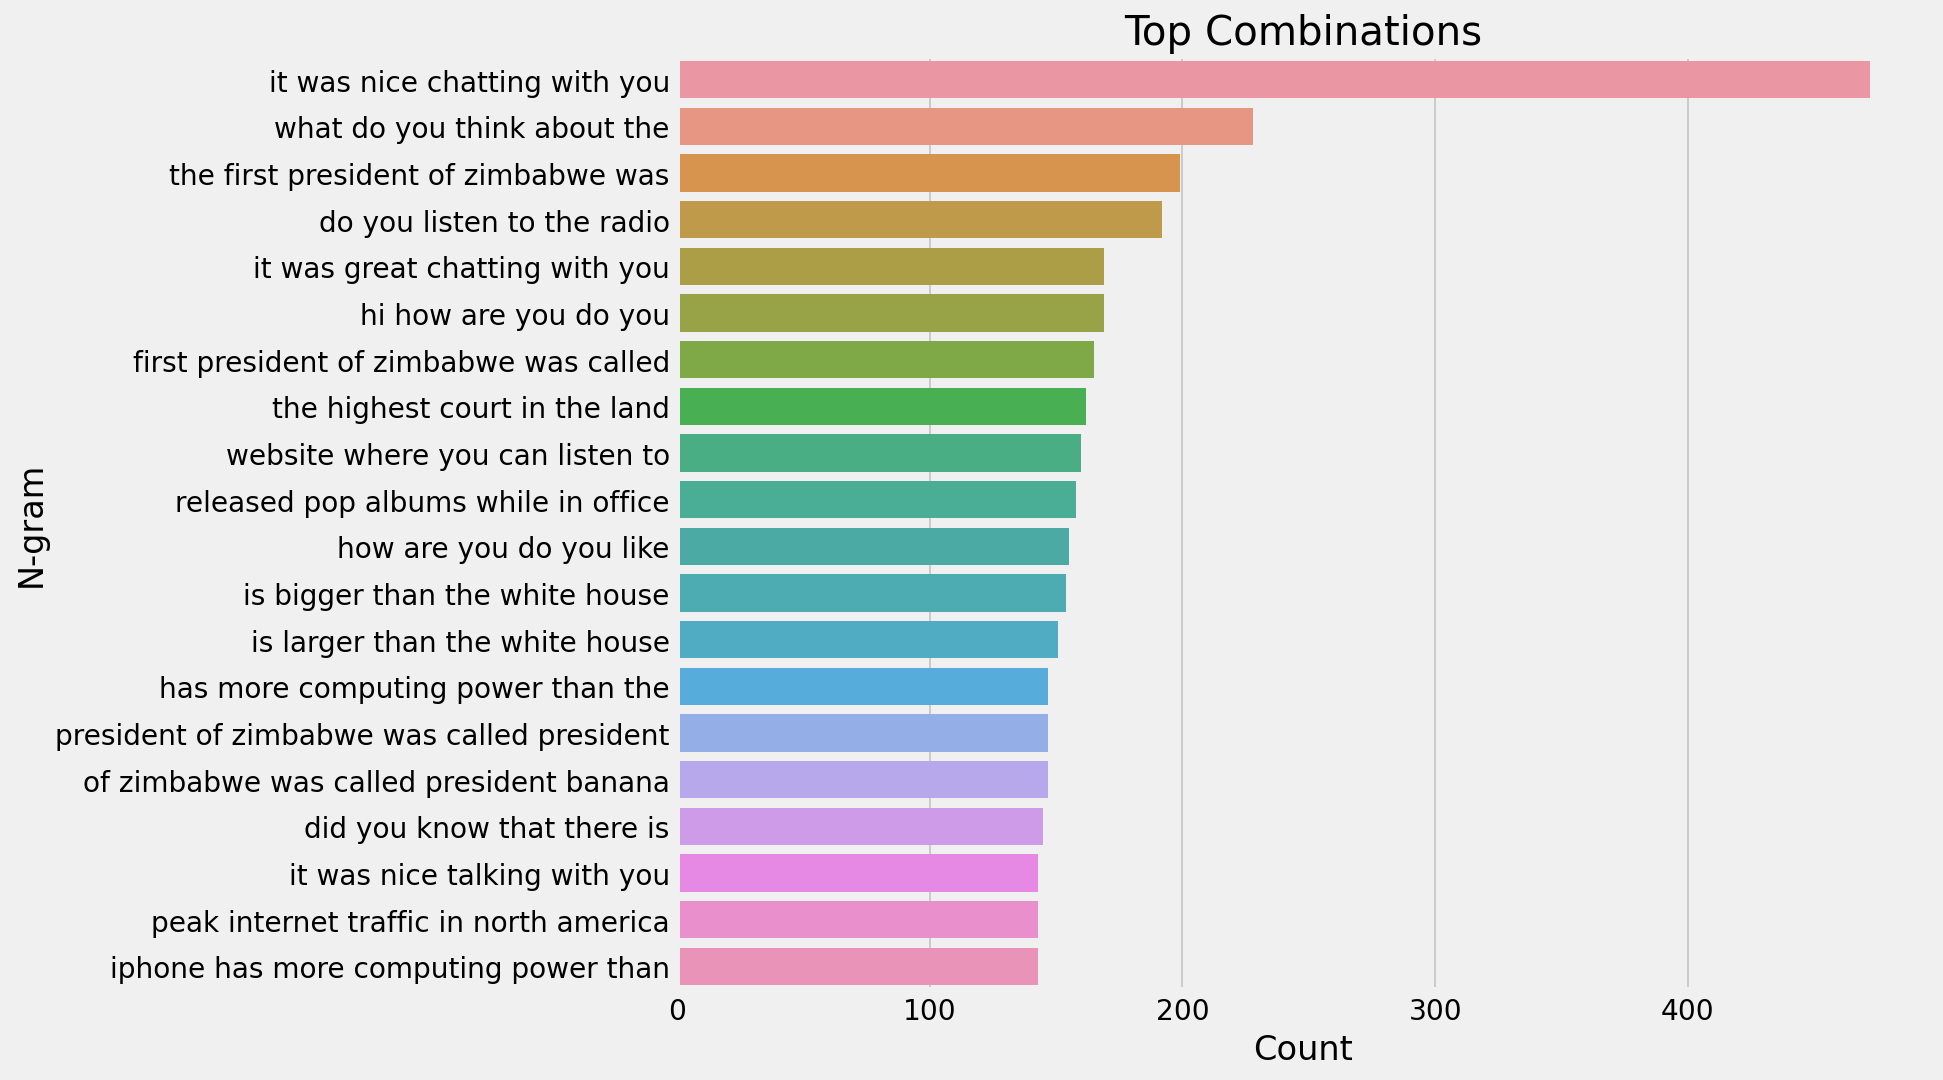

In [22]:
plot_n_gram(text, 6);

I noticed mention of the White House before, but it's more frequent here.

Also, we seem to have the answer for why Zimbabwe was in the news, "of zimbabwe was called president banana".

Finally, one can only hope that since "it was nice chatting with you" was the most frequent n-gram 6 words in length that that bodes well for our future chatbot's politness.



<br>

## 2.2 TOPIC MODELING

The aim here is to use unsupervised learning to extract the main topics within this corpus.

In [26]:
#pre-processing the data so it can be modeled 
def preprocess_messages(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for topical in df['message']:
        words=[w for w in word_tokenize(topical) if (w not in stop)] #tokenizing and removing stopwords
        
        words=[lem.lemmatize(w) for w in words if len(w)>2] #lemmatizing to common bases/roots
        
        corpus.append(words)
    return corpus

corpus=preprocess_messages(topical)

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
#creating a bag of words model using gensim
dic=gensim.corpora.Dictionary(corpus)
bag_of_words_corpus = [dic.doc2bow(doc) for doc in corpus]

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
#using LDA (Latent Dirichlet Allocation) to create a topic model
lda_model = gensim.models.LdaMulticore(bag_of_words_corpus, 
                                   num_topics = 8, 
                                   id2word = dic,                                    
                                   passes = 10)

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
vis = gensimvis.prepare(lda_model, bag_of_words_corpus, dic)
vis

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.031592  0.010697       1        1  19.129982
4      0.077770 -0.077985       2        1  15.113613
5      0.118712  0.039493       3        1  12.379215
3     -0.072080  0.167688       4        1  11.651661
2      0.008202  0.063178       5        1  11.645490
7      0.069950  0.102648       6        1  11.379835
1      0.082825 -0.228808       7        1   9.770681
0     -0.316971 -0.076910       8        1   8.929524, topic_info=           Term         Freq         Total Category  logprob  loglift
1444      radio  7662.000000   7662.000000  Default  30.0000  30.0000
315       great  7734.000000   7734.000000  Default  29.0000  29.0000
638       watch  8058.000000   8058.000000  Default  28.0000  28.0000
1803  president  8239.000000   8239.000000  Default  27.0000  27.0000
3           fan  4885.000000   4885.000000  Default  26.0000  26.0000
...         ...          ...           ...      ...      ...      ...
270        That  1799.219438  18349.741099   Topic8  -4.5643   0.0935
77          Yes  1521.576396  12136.465306   Topic8  -4.7319   0.3393
312         How  1017.133775   3299.075232   Topic8  -5.1347   1.2392
31         Yeah  1285.683445  13840.667064   Topic8  -4.9004   0.0395
141       heard   902.562879   6942.139114   Topic8  -5.2542   0.3757

[523 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
372       1  0.330062   ...
372       2  0.148257   ...
372       3  0.082786   ...
372       4  0.028678   ...
372       5  0.121203   ...
...     ...       ...   ...
421       4  0.023241  year
421       5  0.153898  year
421       6  0.025774  year
421       7  0.128124  year
421       8  0.087601  year

[931 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 6, 4, 3, 8, 2, 1])

I was hoping that this would somehow pull out the 8 topic categories on its own, but unfortunately it hasn't. 

To my eyes, there does not seem to be anything linking the topics that immediately jumps out.

<b>Note:</b> there is supposed to be a graph above this cell. In some instances after the cell is run and the notebook is closed however, it does not subsequently appear. To see what the chart looks like, you can rerun the above code.

<br>

## 2.3 SENTIMENT ANALYSIS

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


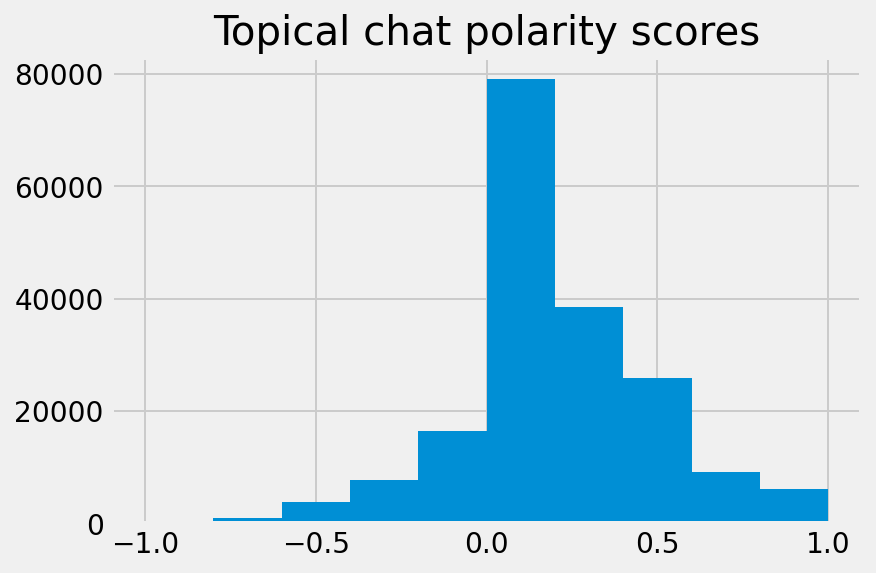

In [31]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

topical['polarity_score']=topical['message'].apply(lambda x : polarity(x))
topical['polarity_score'].hist()
plt.title("Topical chat polarity scores");

The messages in this dataset seem to lean towards the positive.

<br>

## 2.4 NAMED ENTITY RECOGNITION

Named Entity Recognition is the process of detecting the named entities such as person names, location names, company names, etc. from the text.

|Type|Description|
|:---|:---|
|**PERSON**|People, including fictional.|
|**NORP**|Nationalities or religious or political groups.|
|**FAC**|Buildings, airports, highways, bridges, etc.|
|**ORG**|Companies, agencies, institutions, etc.|
|**GPE**|Countries, cities, states.|
|**LOC**|Non-GPE locations, mountain ranges, bodies of water.|
|**PRODUCT**|Objects, vehicles, foods, etc. (Not services.)|
|**EVENT**| Named hurricanes, battles, wars, sports events, etc.|
|**WORK_OF_ART**|Titles of books, songs, etc.|
|**LAW**|Named documents made into laws.|
|**LANGUAGE**|Any named language.|
|**DATE**|Absolute or relative dates or periods.|
|**TIME**|Times smaller than a day.|
|**PERCENT**|Percentage, including ”%“.|
|**MONEY**|Monetary values, including unit.|
|**QUANTITY**|Measurements, as of weight or distance.|
|**ORDINAL**|“first”, “second”, etc|
|**CARDINAL**| Numerals that do not fall under another type.|

In [32]:
nlp = spacy.load("en_core_web_sm") #loading a pre-trained name entity recognition model

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


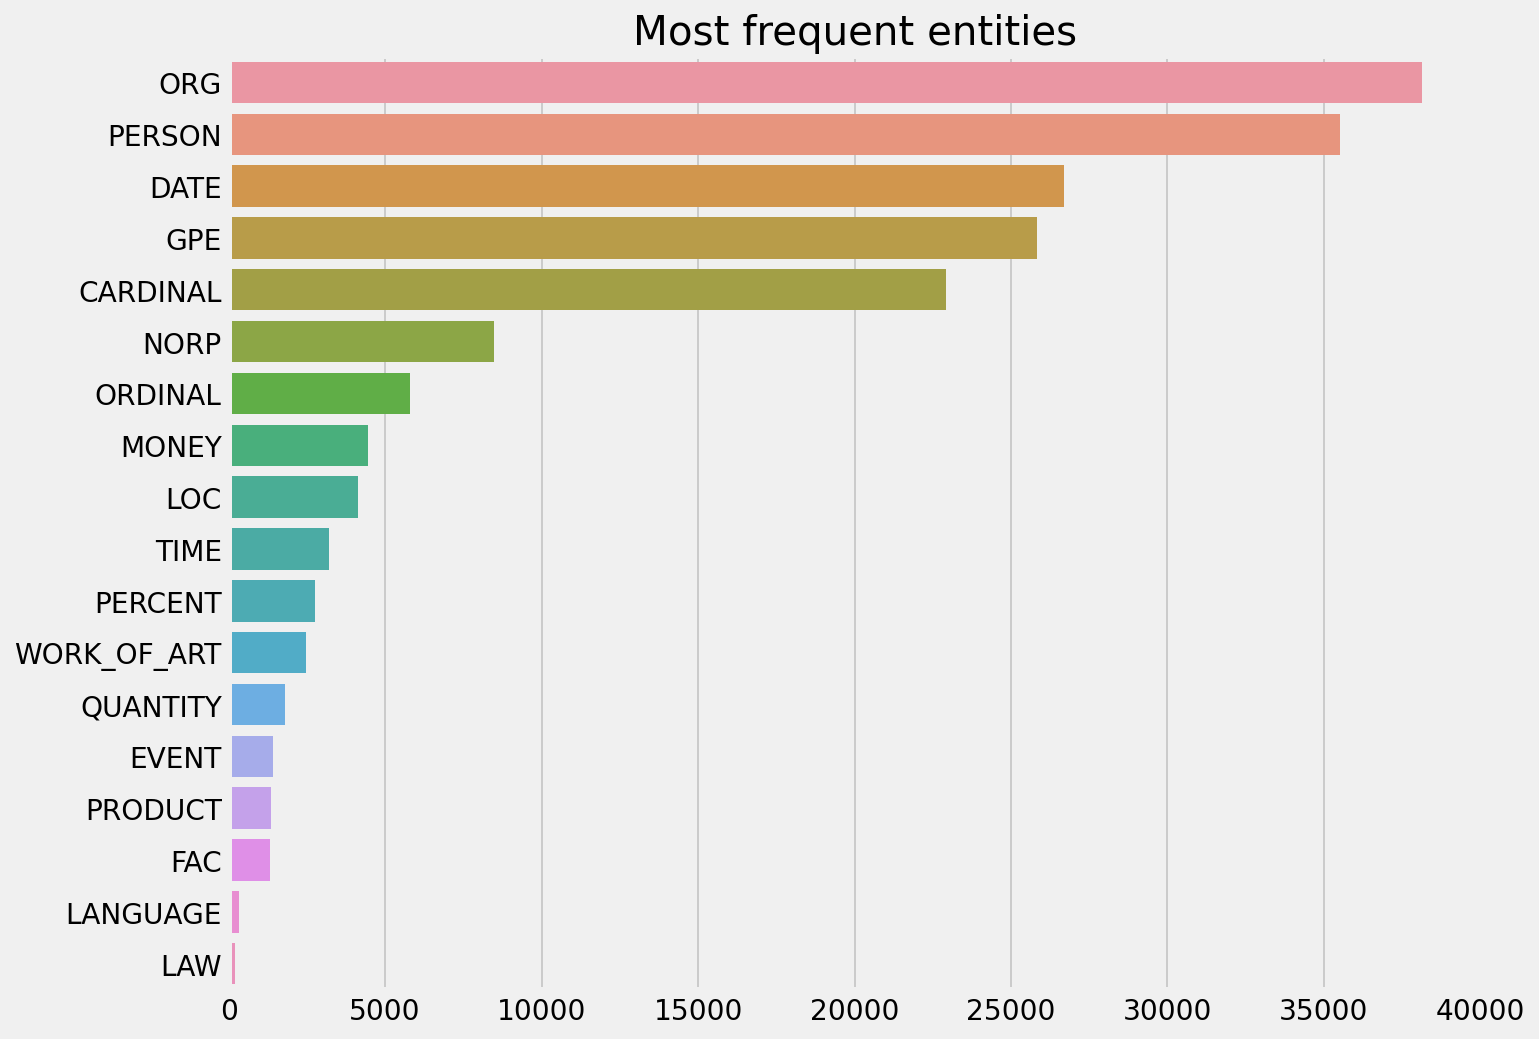

In [33]:
def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

ent=topical['message'].apply(lambda x : ner(x))
ent=[x for sub in ent for x in sub]

counter=Counter(ent)
count=counter.most_common()

x,y=map(list,zip(*count))
plt.figure(figsize=(10, 8))
sns.barplot(x=y,y=x)
plt.title("Most frequent entities");

Organizations, and persons are the most popular entity type, closely followed by dates and political units (countries, states, cities).

<br>

## 2.4 PARTS OF SPEECH TAGGING

Parts of speech tagging assigns parts of speech labels to words in a sentence.

|Part of Speech|Definition|
|:---|:---|
|**CC**|coordinating conjunction|
|**CD**|cardinal digit|
|**DT**|determiner|
|**EX**|existential there|
|**FW**|foreign word|
|**IN**|preposition/subordinating conjunction|
|**JJ**|This NLTK POS Tag is an adjective (large)|
|**JJR**|adjective, comparative (larger)|
|**JJS**|adjective, superlative (largest)|
|**LS**|list market|
|**MD**|modal (could, will)|
|**NN**|noun, singular (cat, tree)|
|**NNS**|noun plural (desks)|
|**NNP**|proper noun, singular (sarah)|
|**NNPS**|proper noun, plural (indians or americans)|
|**PDT**|predeterminer (all, both, half)|
|**POS**|possessive ending (parent\ ‘s)|
|**PRP**|personal pronoun (hers, herself, him, himself)|
|**PRP(dollar sign)**|possessive pronoun (her, his, mine, my, our )|
|**RB**|adverb (occasionally, swiftly)|
|**RBR**|adverb, comparative (greater)|
|**RBS**|adverb, superlative (biggest)|
|**RP**|particle (about)|
|**TO**|infinite marker (to)|
|**UH**|interjection (goodbye)|
|**VB**|verb (ask)|
|**VBG**|verb gerund (judging)|
|**VBD**|verb past tense (pleaded)|
|**VBN**|verb past participle (reunified)|
|**VBP**|verb, present tense not 3rd person singular(wrap)|
|**VBZ**|verb, present tense with 3rd person singular (bases)|
|**WDT**|wh-determiner (that, what)|
|**WP**|wh- pronoun (who)|
|**WRB**|wh- adverb (how)|

In [34]:
def pos(text):
    pos=nltk.pos_tag(word_tokenize(text))
    pos=list(map(list,zip(*pos)))[1]
    return pos

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
def text_sanitizer(text):
    
    remove_special_characters = re.sub("[^a-zA-Z0-9]", " ", text)

    return remove_special_characters

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
topical['clean_text'] = topical['message'].apply(text_sanitizer)

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
tags=topical['clean_text'][:10_000].apply(lambda x : pos(x))#kept getting an error, so I had to restrict this to the first 10k messages
tags=[x for l in tags for x in l]
counter=Counter(tags)

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


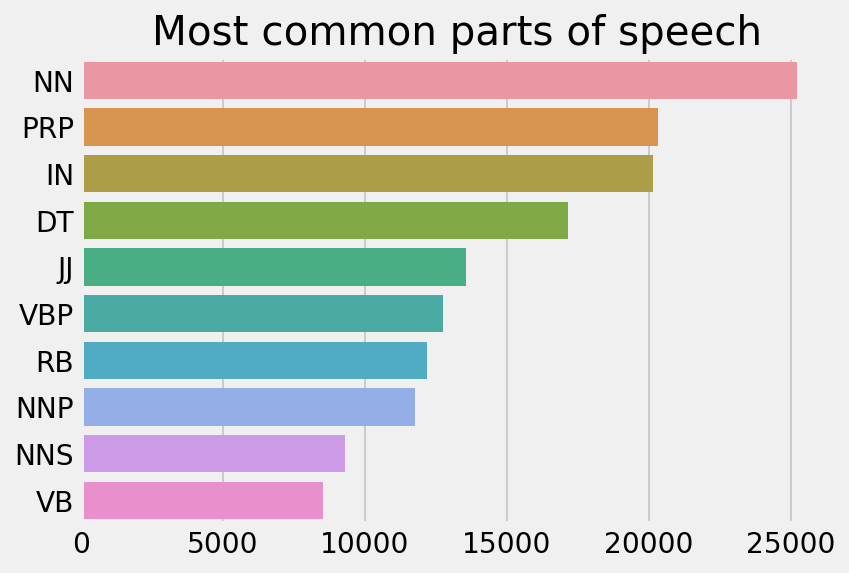

In [39]:
x,y=list(map(list,zip(*counter.most_common(10))))
sns.barplot(x=y,y=x)
plt.title("Most common parts of speech");

<br>

## 2.5 TEXT COMPLEXITY

The following values are based on the Flesh Reading Ease scale:

|Score|Interpretation|
|:---|:---|
|**0-30**|College|
|**50-60**|High School|
|**60+**|Fourth grade|

Essentially, the lower the course, the more difficult a text is to understand.

/Applications/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


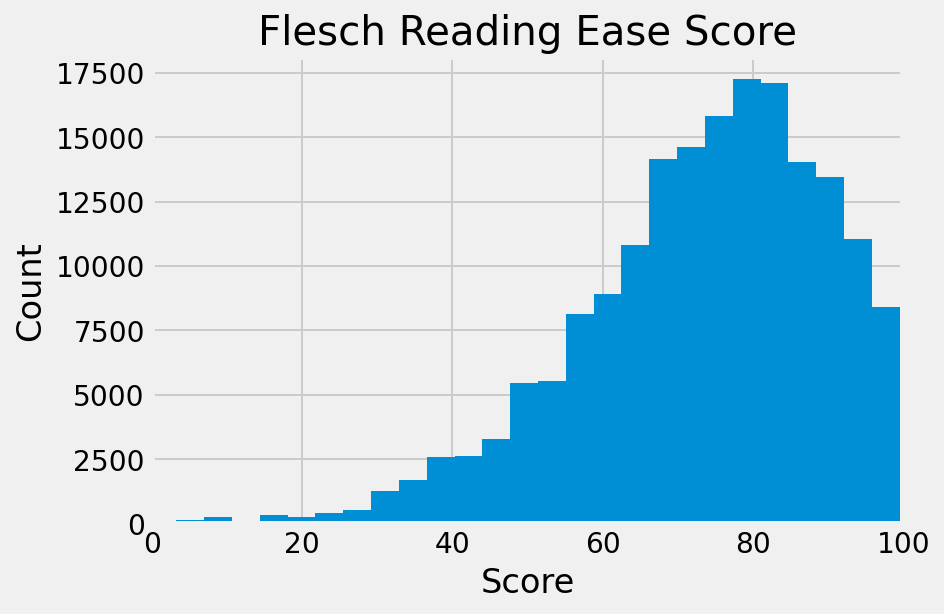

In [40]:
from textstat import flesch_reading_ease

topical['message'].apply(lambda x : flesch_reading_ease(x)).hist(bins=500)
plt.xlim(0, 100)
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Flesch Reading Ease Score");

The messages in this dataset lean heavily towards the simple.

Since the messages aren't overly complex, I feel like that bodes one for developing a model that can mimick their reading level.